## Импортируем все необходимые библиотеки

In [7]:
import warnings
import gc
warnings.filterwarnings("ignore")
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
#rcParams[]
import seaborn as sns
import pickle

In [62]:
rcParams['figure.figsize'] = 15, 10

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.stats.api as ssm
from scipy import stats

In [10]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [11]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegressionCV, LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, log_loss, r2_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

## Загрузка данных

Загружаю данные.
Sales - таблица всех продаж с детализацией по Дате, магазину и департаменту.
Features - много разных признаков с детализацией по дням
Stores - данные магазинов
Заодно сразу смотрю, сколько пропущенных значений в таблицах

In [12]:
features = pd.read_csv('Features data set.csv', parse_dates=['Date'], dayfirst=True)

sales = pd.read_csv('sales data-set.csv', parse_dates=['Date'], dayfirst=True)

stores = pd.read_csv('stores data-set.csv') #("../input")

In [13]:
features.shape, sales.shape, stores.shape

((8190, 12), (421570, 5), (45, 3))

In [14]:
print('Количество уникальных записей по Store и Date: {}'.format(len(sales.groupby(['Date', 'Store']).groups)))

sales.head()

Количество уникальных записей по Store и Date: 6435


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [15]:

print('Количество уникальных записей по Store и Date: {}'.format(len(features.groupby(['Date', 'Store']).groups)))

features.head()

Количество уникальных записей по Store и Date: 8190


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [16]:
features.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [17]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## Missing values
    Надо избавиться от пропущенных значений.
    В данных отсутствуют строки, соответствующие нулевым значениям продаж. 
    
    Кроме того, в описании к датасету указано, что столбцы Markdown1-5 были добавлены в ноябре 2011 года, все более ранние значения этих колонок не заполнены. Но эти столбцы я решила пока не заполнять.

    Я сделала итератор по всем значениям Даты, Магазина и Департамента, аналогичный функции product из библиотеки itertools, в последней версии которой почему-то этой функции нет D=
    После этого объединяю все таблицы между собой

In [18]:
arr =[]

In [19]:
for d in sales.Date.unique():
    for dept in sales.Dept.unique():
        for s in sales.Store.unique():
            arr.append([d, dept, s])

In [20]:
all_values = pd.DataFrame.from_records(arr, columns=['Date', 'Dept', 'Store'])

In [21]:
whole_sales = pd.merge(all_values, sales.drop('IsHoliday', axis=1), on=['Date', 'Dept', 'Store'], how = 'left')
whole_sales.Weekly_Sales.fillna(0, inplace=True)

In [22]:
whole_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521235 entries, 0 to 521234
Data columns (total 4 columns):
Date            521235 non-null datetime64[ns]
Dept            521235 non-null int64
Store           521235 non-null int64
Weekly_Sales    521235 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 19.9 MB


In [23]:
whole_sales.shape

(521235, 4)

## Generating Feature

In [24]:
def create_new_features(whole_sales, features, stores):
    
    datas = pd.to_datetime(pd.unique(sales.Date), format="%d/%m/%Y")
    
    date_dict = {k:v for k,v in zip(datas, datas.week)}

    whole_sales['week'] = whole_sales.Date.apply(lambda x: date_dict[x])

    whole_sales['year'] = whole_sales.Date.apply(lambda x: x.year)

    whole_sales['month'] = whole_sales.Date.apply(lambda x: x.month)

    whole_sales['day'] = whole_sales.Date.apply(lambda x: x.day)
    
    # Флаги пред- и постпраздничных недель
    df_of_holidays = sales.groupby(['Date', 'IsHoliday']).Store.nunique().reset_index()[['Date', 'IsHoliday']]

    df_of_holidays['post_holiday'] = df_of_holidays.IsHoliday.shift(1)
    df_of_holidays['pred_holiday'] = df_of_holidays.IsHoliday.shift(-1)
    df_of_holidays = df_of_holidays.fillna(False)

    whole_sales = pd.merge(whole_sales, df_of_holidays.drop('IsHoliday', axis=1), on='Date')
    whole_data_with_markdown = whole_sales.merge(features, on=['Date', 'Store'])
    whole_data_with_markdown = whole_data_with_markdown.merge(stores, on=['Store'])
    
    #закодируем булевы переменные
    encoder = LabelEncoder()
    
    whole_data_with_markdown['Type'] = encoder.fit_transform(whole_data_with_markdown['Type'])

    whole_data_with_markdown['IsHoliday'] = encoder.fit_transform(whole_data_with_markdown['IsHoliday'])
    whole_data_with_markdown['post_holiday'] = encoder.fit_transform(whole_data_with_markdown['IsHoliday'])
    whole_data_with_markdown['pred_holiday'] = encoder.fit_transform(whole_data_with_markdown['IsHoliday'])
    
    return whole_data_with_markdown

In [25]:
whole_data_with_markdown = create_new_features(whole_sales, features, stores)

In [26]:
whole_data_with_markdown.head()

,Date,Dept,Store,Weekly_Sales,week,year,month,day,post_holiday,pred_holiday,...,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,2010-02-05,1,1,24924.50,5,2010,2,5,0,0,...,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,0,0,151315
1,2010-02-05,2,1,50605.27,5,2010,2,5,0,0,...,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,0,0,151315
2,2010-02-05,3,1,13740.12,5,2010,2,5,0,0,...,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,0,0,151315
3,2010-02-05,4,1,39954.04,5,2010,2,5,0,0,...,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,0,0,151315
4,2010-02-05,5,1,32229.38,5,2010,2,5,0,0,...,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,0,0,151315


In [27]:
whole_data_with_markdown.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521235 entries, 0 to 521234
Data columns (total 22 columns):
Date            521235 non-null datetime64[ns]
Dept            521235 non-null int64
Store           521235 non-null int64
Weekly_Sales    521235 non-null float64
week            521235 non-null int64
year            521235 non-null int64
month           521235 non-null int64
day             521235 non-null int64
post_holiday    521235 non-null int64
pred_holiday    521235 non-null int64
Temperature     521235 non-null float64
Fuel_Price      521235 non-null float64
MarkDown1       184680 non-null float64
MarkDown2       132597 non-null float64
MarkDown3       165726 non-null float64
MarkDown4       159165 non-null float64
MarkDown5       185895 non-null float64
CPI             521235 non-null float64
Unemployment    521235 non-null float64
IsHoliday       521235 non-null int64
Type            521235 non-null int64
Size            521235 non-null int64
dtypes: datetime64[ns](1

## Предварительный анализ

### Средние продажи за день по всем департаментам всех мазагинов.
Видно, что продажи имеют очень яркие пики в преддверии января (рождество и новый год)

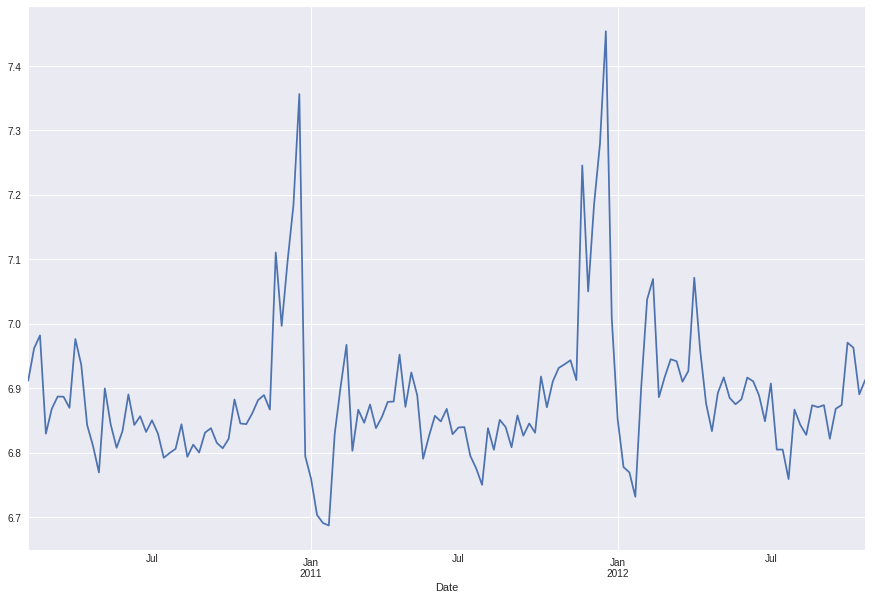

In [63]:
fig, ax = plt.subplots()
whole_data_with_markdown.groupby('Date').Weekly_Sales.mean().plot(x='Date', y='Weekly_Sales', ax=ax);
ax.xticks = whole_data_with_markdown.groupby('Date')
plt.show()

### Объемы продаж за все время с разбивкой по магазинам и департаментам
Данные очень шумные. Нет однозначных магазинов/департаментов, у которых все значения были бы максимальными/минимальными

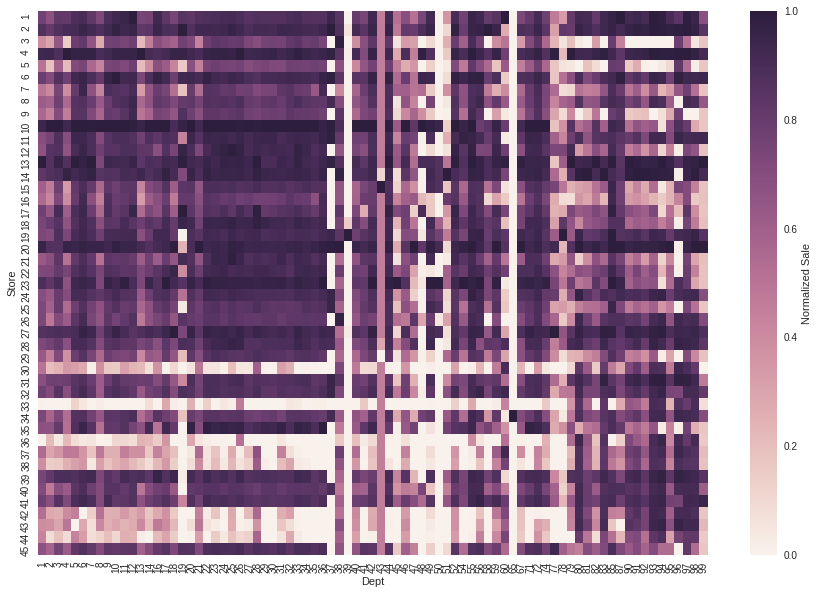

In [64]:
df_stores_depts = whole_data_with_markdown.groupby(['Store', 'Dept']).sum().reset_index()

df_stores_depts = df_stores_depts.pivot(index='Store', columns='Dept', values='Weekly_Sales')


ax = sns.heatmap(df_stores_depts.apply(lambda col: (col-min(col))/(max(col)-min(col)), axis=0), cbar_kws={'label': 'Normalized Sale'})

### Анализ данных Markdown
Я хочу проанализировать данные на предмет того, влияют ли значения столбцов Markdown на объем продаж.

Из данных видно, что значения колонок постоянны у каждого магазина в течение дня.

In [30]:
whole_data_with_markdown_new = whole_data_with_markdown[(whole_data_with_markdown.Date >= pd.datetime(2011,11,5))]

In [31]:
markdown_cols = [x for x in features.columns if 'MarkDown' in x]

In [32]:
whole_data_with_markdown_new['markdown_sum'] = whole_data_with_markdown[markdown_cols].sum(axis=1)

In [33]:
whole_data_with_markdown_new.head()

,Date,Dept,Store,Weekly_Sales,week,year,month,day,post_holiday,pred_holiday,...,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,markdown_sum
7452,2011-11-11,1,1,18689.54,45,2011,11,11,0,0,...,6115.67,215.07,2406.62,6551.42,217.998085,7.866,0,0,151315,25671.68
7453,2011-11-11,2,1,44936.47,45,2011,11,11,0,0,...,6115.67,215.07,2406.62,6551.42,217.998085,7.866,0,0,151315,25671.68
7454,2011-11-11,3,1,9959.64,45,2011,11,11,0,0,...,6115.67,215.07,2406.62,6551.42,217.998085,7.866,0,0,151315,25671.68
7455,2011-11-11,4,1,36826.52,45,2011,11,11,0,0,...,6115.67,215.07,2406.62,6551.42,217.998085,7.866,0,0,151315,25671.68
7456,2011-11-11,5,1,31002.65,45,2011,11,11,0,0,...,6115.67,215.07,2406.62,6551.42,217.998085,7.866,0,0,151315,25671.68


In [34]:
whole_data_with_markdown_new.groupby(['Date', 'Store']).markdown_sum.nunique().reset_index().groupby('markdown_sum').Store.count()

markdown_sum
1    2295
Name: Store, dtype: int64

In [35]:
average_promo_sales = whole_data_with_markdown_new.groupby(['Date'])['Weekly_Sales','markdown_sum'].mean().reset_index()

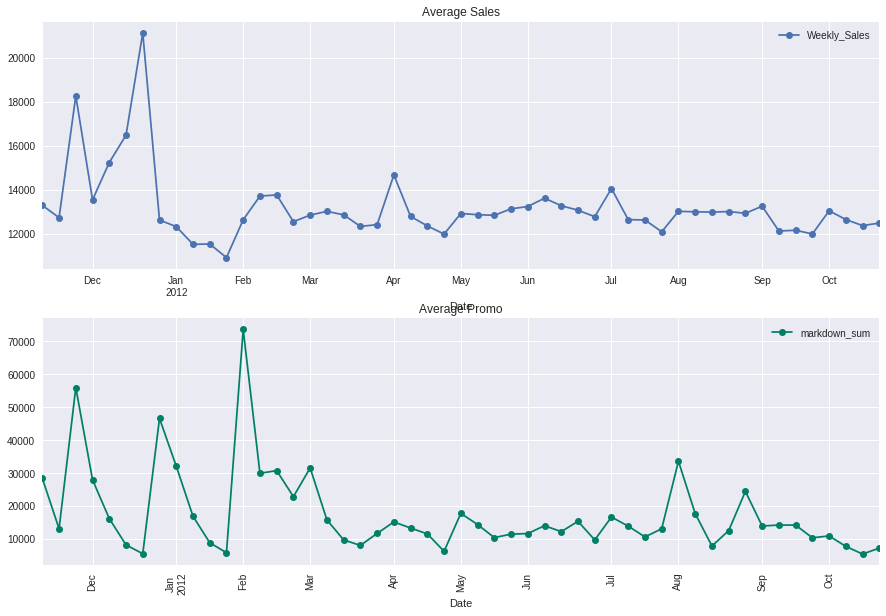

In [65]:
fig, (axis1, axis2) = plt.subplots(2,1)
ax1 = average_promo_sales.plot(y='Weekly_Sales', x='Date', legend=True,ax=axis1,marker='o',title="Average Sales")
ax2 = average_promo_sales.plot(y='markdown_sum', x='Date', legend=True,ax=axis2,marker='o',rot=90,colormap="summer",title="Average Promo")

### Постороение гистограммы значений целевой переменной

Распределение очень отличается от нормального, поэтому я решила логарифмировать значения продаж

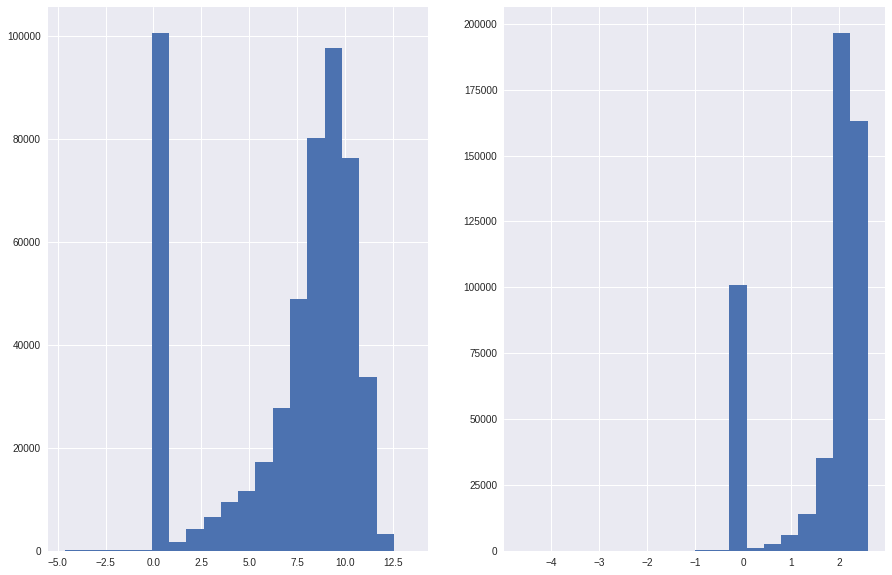

In [66]:
fig, axis = plt.subplots(1,2)

whole_data_with_markdown.Weekly_Sales.hist(bins=20, ax=axis[0])

whole_data_with_markdown.Weekly_Sales.apply(lambda x: 0 if x<=0 else np.log(x)).hist(bins=20, ax=axis[1])

In [38]:
whole_data_with_markdown.Weekly_Sales = whole_data_with_markdown.Weekly_Sales.apply(lambda x: 0 if x==0 else np.log(x))

In [39]:
whole_data_with_markdown.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521235 entries, 0 to 521234
Data columns (total 22 columns):
Date            521235 non-null datetime64[ns]
Dept            521235 non-null int64
Store           521235 non-null int64
Weekly_Sales    519950 non-null float64
week            521235 non-null int64
year            521235 non-null int64
month           521235 non-null int64
day             521235 non-null int64
post_holiday    521235 non-null int64
pred_holiday    521235 non-null int64
Temperature     521235 non-null float64
Fuel_Price      521235 non-null float64
MarkDown1       184680 non-null float64
MarkDown2       132597 non-null float64
MarkDown3       165726 non-null float64
MarkDown4       159165 non-null float64
MarkDown5       185895 non-null float64
CPI             521235 non-null float64
Unemployment    521235 non-null float64
IsHoliday       521235 non-null int64
Type            521235 non-null int64
Size            521235 non-null int64
dtypes: datetime64[ns](1

### Матрица корреляции признаков

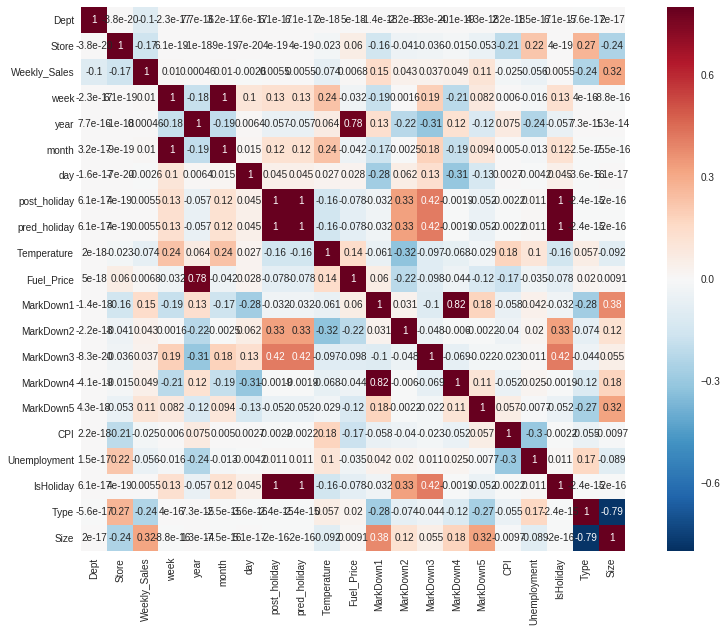

In [67]:
corrmat = whole_data_with_markdown.corr()
sns.heatmap(corrmat, vmax=.8, square=True, annot=True);

# Моделирование
После визуального анализа стало понятно, что данные имеют очень четкую структуру во времени, и, видимо, сильно автокоррелированы.

Я предприняла попытку использовать прогнозную модель ARIMA для решения поставленной задачи. Я построила модель для всех продаж всех магазинов, без разбивки по магазинам и департаментам, а также для одного из магазинов. 
Оказалось, что динамика продаж отличается у разных магазинов (и, вероятно, у их департаментов),
и вместо того, чтобы настраивать для каждого из них модель вручную, было решено использовать регрессионный подход к прогнозированию.

Я ориентировалась на две метрики - r2 и rmse.
RMSE легко минимизировать, но она слишком штрафует за большие отклонения от правильного ответа.
Из-за того, что наши данные имеют много сильных (и очень сильных) выбросов, она не очень подходит..

R2 может быть интерпретируема как доля дисперсии, объясненной используемой моделью.

Я попробовала использовать для обучения два набора данных:

1) данные за весь период, удалив оттуда столбцы Markdown1-5

2) данные, начиная с ноября 2011 года, не удаляя эти столбцы


## Регрессионный подход к прогнозированию

In [41]:
whole_data = whole_data_with_markdown.drop(markdown_cols, axis=1)

In [42]:
whole_data.head()

,Date,Dept,Store,Weekly_Sales,week,year,month,day,post_holiday,pred_holiday,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size
0,2010-02-05,1,1,10.123607,5,2010,2,5,0,0,42.31,2.572,211.096358,8.106,0,0,151315
1,2010-02-05,2,1,10.831811,5,2010,2,5,0,0,42.31,2.572,211.096358,8.106,0,0,151315
2,2010-02-05,3,1,9.528075,5,2010,2,5,0,0,42.31,2.572,211.096358,8.106,0,0,151315
3,2010-02-05,4,1,10.595485,5,2010,2,5,0,0,42.31,2.572,211.096358,8.106,0,0,151315
4,2010-02-05,5,1,10.380634,5,2010,2,5,0,0,42.31,2.572,211.096358,8.106,0,0,151315


In [43]:
whole_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521235 entries, 0 to 521234
Data columns (total 17 columns):
Date            521235 non-null datetime64[ns]
Dept            521235 non-null int64
Store           521235 non-null int64
Weekly_Sales    519950 non-null float64
week            521235 non-null int64
year            521235 non-null int64
month           521235 non-null int64
day             521235 non-null int64
post_holiday    521235 non-null int64
pred_holiday    521235 non-null int64
Temperature     521235 non-null float64
Fuel_Price      521235 non-null float64
CPI             521235 non-null float64
Unemployment    521235 non-null float64
IsHoliday       521235 non-null int64
Type            521235 non-null int64
Size            521235 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(11)
memory usage: 71.6 MB


In [44]:
with open('whole_data.pkl', 'wb') as f:
    pickle.dump(whole_data, f)

### Отделяю отложенную выборку

In [45]:
def train_test_spl(whole_data, test_len=16):
    whole_data = whole_data.fillna(0)
    whole_data = whole_data.sort_values(by='Date')
    
    unique_date = whole_data.Date.unique()[-test_len:]
    
    train = whole_data[~whole_data.Date.isin(unique_date)]
    test = whole_data[whole_data.Date.isin(unique_date)]
    
    return [train, test]

In [46]:
train, test = train_test_spl(whole_data, 16)

In [47]:
train_m, test_m = train_test_spl(whole_data_with_markdown_new, 16)

## Разбиение датасета на фолды

In [48]:
cv_splits = TimeSeriesSplit(n_splits=10)

In [49]:
gc.collect()

66726

In [50]:
estimators =[RandomForestRegressor(n_estimators=100, max_features ='sqrt'),
             KNeighborsRegressor(n_neighbors=6),
             ExtraTreesRegressor(n_estimators=20, criterion='mse', bootstrap=True, n_jobs=-1, random_state=17)
            ]

In [51]:
def plot_scores(test, group_cols = 'Date'):
    
    for col in group_cols:
        if col not in test.columns:
            return 'group columns not exist in test dataframe'
    
    ttest = test.groupby(by=group_cols)[['Weekly_Sales', 'predict_y']].mean()

    fig, ax = plt.subplots()
    ttest.plot(y='Weekly_Sales', ax=ax)
    ttest.plot(y='predict_y', ax=ax)
    ax.set_title('Mean squared error: {}. r2-score : {}'.format(mean_squared_error(test.Weekly_Sales, test.predict_y), r2_score(test.Weekly_Sales, test.predict_y)))
    plt.show()

In [52]:
def scale_set(x):
    scaler = StandardScaler()
    return scaler.fit_transform(x)

In [53]:
def x_y_split(x_y):
    X = x_y.drop(['Weekly_Sales', 'Date'], axis=1)
    y = x_y['Weekly_Sales']
    return [X,y]

In [54]:
scores = pd.DataFrame()
tmp = {}
for m,est in zip(['RandomForestRegressor', 'KNeighborsRegressor', 'ExtraTreesRegressor'], estimators):
    tmp['Model'] = m
    for j,i in enumerate([train, train_m]):
        X_train, y_train = x_y_split(i)
        cv_scores = cross_val_score(est, scale_set(X_train), y_train, cv=cv_splits, scoring='r2')
        tmp['R2_Y%s'%str(j+1)] = np.mean(cv_scores)
    scores = scores.append([tmp])
    scores.set_index('Model', inplace=True)

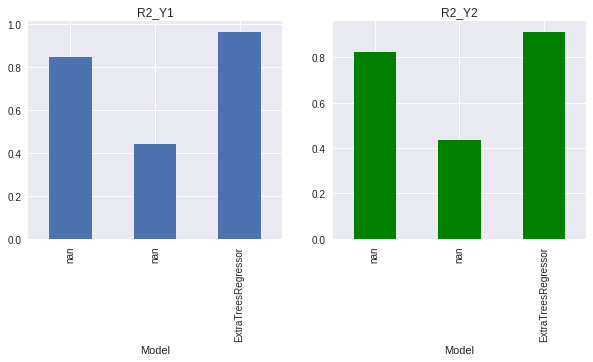

In [68]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
scores.R2_Y1.plot(ax=axes[0], kind='bar', title='R2_Y1')
scores.R2_Y2.plot(ax=axes[1], kind='bar', color='green', title='R2_Y2')

### Лучше всего с задачей справился ExtraTreesRegressor при обучении на данных без столбцов Markdown

In [56]:
etr = ExtraTreesRegressor(n_estimators=20, criterion='mse', bootstrap=True, n_jobs=-1, random_state=17)
X_train, y_train = x_y_split(train)
X_test, y_test = x_y_split(test)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
etr.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=17,
          verbose=0, warm_start=False)

In [57]:
test['Weekly_Sales'] = test.Weekly_Sales.apply(lambda x: np.e**x)
pred_y = list(map(lambda x: np.e**x, etr.predict(X_test)))

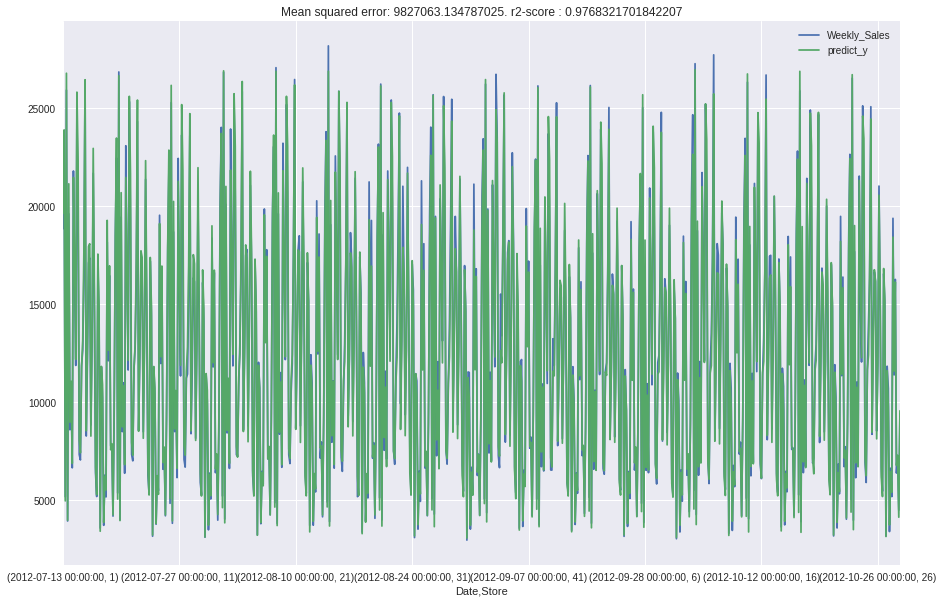

In [69]:
plot_scores(test.assign(predict_y=pred_y), ['Date', 'Store'])

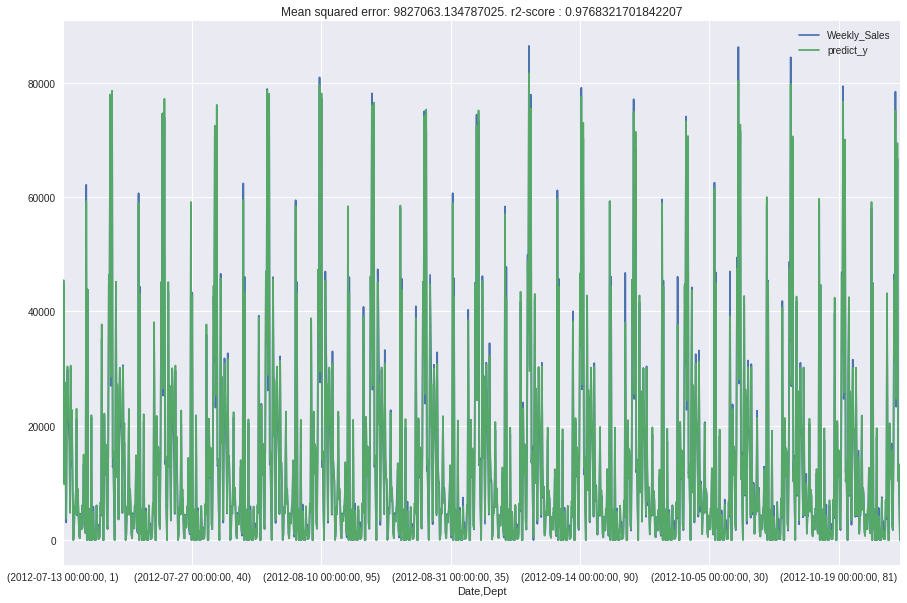

In [70]:
plot_scores(test.assign(predict_y = pred_y), ['Date', 'Dept'])

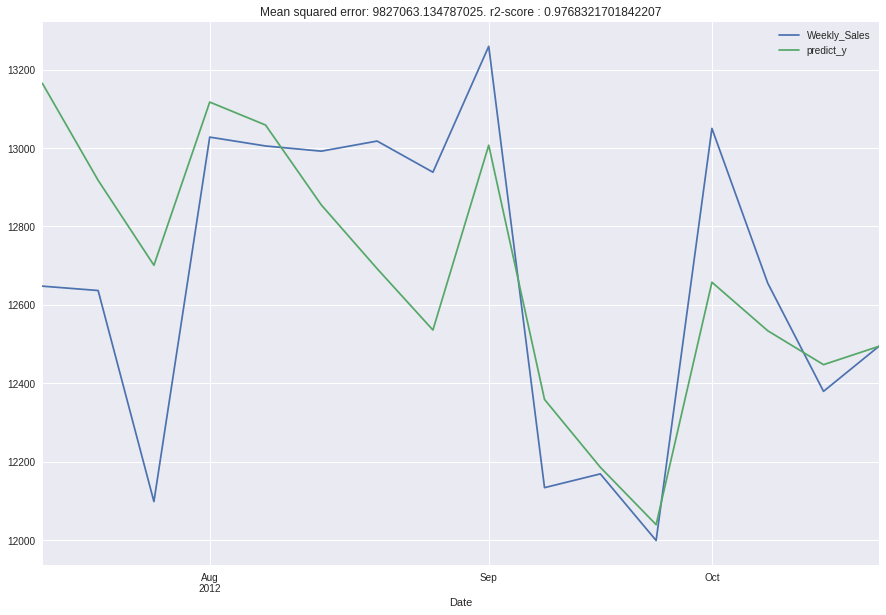

In [71]:

plot_scores(test.assign(predict_y=pred_y), ['Date'])

Видно, что прогноз улавливает структурy пиков и провалов!

На графиках с детализацией также видно, что модель хорошо предсказывает будущее.

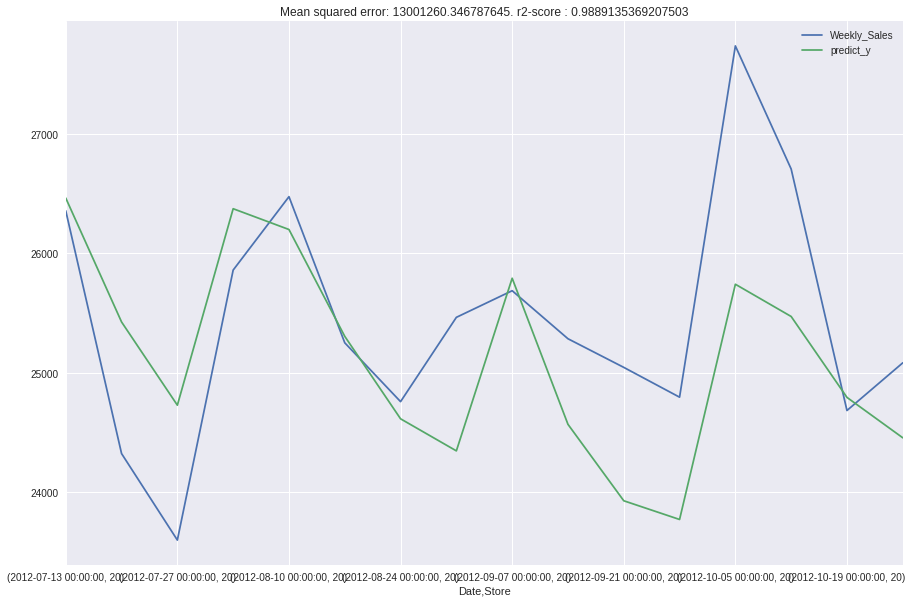

In [72]:
plot_scores(test.assign(predict_y=pred_y)[test.Store == 20], ['Date', 'Store'])

### Идеи по улучшению модели:
Проанализировать влияние признаков на модель, найти комбинацию признаков, которая давала бы наиболее устойчивый результат.

Проанализировать остатки на наличие в них структуры (автокорреляции, смещенности), и в случае нахождения постараться от неё избавиться.

Попробовать какие-нибудь более сложные модели (xgboost, catboost), а также какие-нибудь архитектуры нейронных сетей.

Кроме того, можно было бы объединить результаты нескольких моделей при помощи стекинга (например даже тех двух моделей, которые у меня обучены на разных массивах данных)
